In [1]:
import sys
from sys import platform
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import pickle
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Math
from tqdm import tqdm

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

sns.set_context('paper')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style({'axes.edgecolor': 'black'})
# sns.set_style("ticks")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')
root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J0655m013/'

nustar_obs1 = [5.975194215490741E+04, 5.975194215490741E+04 + (8.186399999976158E+04/(3600*24))]
# obs1_freq = [0.0008852178554669009, 6.514833401702306e-09] # nharm = 1
obs1_freq = [0.0008856113733277114, 3.2805179578745355e-08] # nharm = 4
nustar_obs2 = [5.980585043905106E+04, 5.980585043905106E+04 + (4.208824998831749E+04/(3600*24))]
# obs2_freq = [0.0008976535039138576, 5.5580782526046156e-08] # nharm = 1
obs2_freq = [0.0009235725465767321, 3.8900667499038016e-07] # nharm = 4

nustar_times = np.array([(nustar_obs1[1]+nustar_obs1[0])/2, (nustar_obs2[1]+nustar_obs2[0])/2])
nustar_time_err = np.array([(nustar_obs1[1]-nustar_obs1[0])/2, (nustar_obs2[1]-nustar_obs2[0])/2])
nustar_freqs = np.array([obs1_freq[0], obs2_freq[0]])
nustar_freq_err = np.array([obs1_freq[1], obs2_freq[1]])

def gaussian(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def Ghosh_Lamb_L37(fdot_mHzperday, mu30):
    return 4.15e4*np.power(mu30, -(1./3.))*np.power(fdot_mHzperday, 7./6.)


In [12]:
gbm_data = fits.open(root_dir + 'GBM/maxij0655_old.fits')
pulse_data = gbm_data[2].data
mask = pulse_data['FREQUENCY'] != 0
# print((pulse_data['FREQUENCY'][mask][1]-pulse_data['FREQUENCY'][mask][0])/((pulse_data['TSTART'][mask][1]-pulse_data['TSTART'][mask][0])*3600*24))
# print(((1/pulse_data['FREQUENCY'][mask][1])-(1/pulse_data['FREQUENCY'][mask][0]))/((pulse_data['TSTART'][mask][1]-pulse_data['TSTART'][mask][0])*3600*24))


maxi_lc = ascii.read(root_dir + 'MAXI/J0655-014_g_lc_1day_all.dat', names = ['MJD', 'rate 2-20keV', 'err 2-20keV', \
                                                                             'rate 2-4keV', 'err 2-4keV', \
                                                                             'rate 4-10keV', 'err 4-10keV', \
                                                                             'rate 10-20keV', 'err 10-20keV'])

maxi_mask = (maxi_lc['MJD'] >= np.min(pulse_data['TSTART'][mask])) * (maxi_lc['MJD'] <= np.min(nustar_obs2[1]))

temp_mjd_gbm_nustar = np.concatenate([pulse_data['PSRTIME'][mask], nustar_times])
mjd_gbm_nustar = temp_mjd_gbm_nustar[np.argsort(temp_mjd_gbm_nustar)]
f_gbm_nustar = np.concatenate([pulse_data['FREQUENCY'][mask], nustar_freqs])[np.argsort(temp_mjd_gbm_nustar)]
ferr_gbm_nustar = np.concatenate([pulse_data['FREQUENCY_ERR'][mask], nustar_freq_err])[np.argsort(temp_mjd_gbm_nustar)]

fdot_mjd = (mjd_gbm_nustar[1:] + mjd_gbm_nustar[:-1])/2
fdot_mjd_err = (mjd_gbm_nustar[1:] - mjd_gbm_nustar[:-1])/2
fdot_mHzperday = 1000.*(f_gbm_nustar[1:] - f_gbm_nustar[:-1])/(mjd_gbm_nustar[1:] - mjd_gbm_nustar[:-1])
fdot_mHzperday_err = 1000.*np.sqrt(np.square(ferr_gbm_nustar[1:]) + np.square(ferr_gbm_nustar[:-1]))/(mjd_gbm_nustar[1:] - mjd_gbm_nustar[:-1])

print(1/f_gbm_nustar[0])

1130.2580579391038


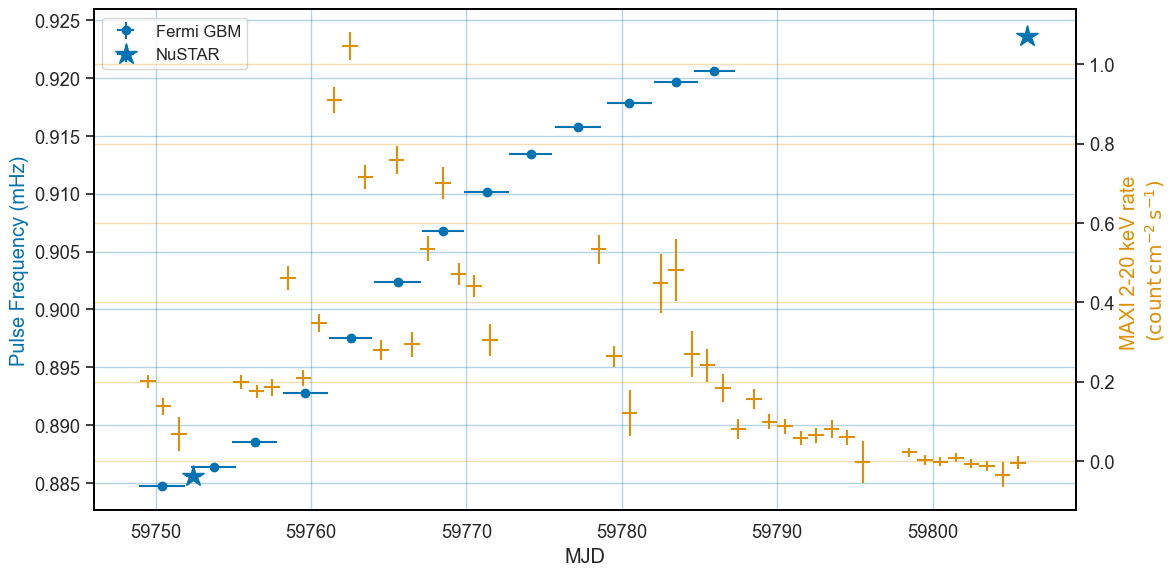

In [3]:
fig, host = plt.subplots(figsize=(12,6))
par1 = host.twinx()

pl1 = host.errorbar(pulse_data['PSRTIME'][mask], pulse_data['FREQUENCY'][mask]*1000, xerr=(pulse_data['TSTOP'][mask]-pulse_data['TSTART'][mask])/2, yerr=pulse_data['FREQUENCY_ERR'][mask]*1000, ls='', fmt='.', label='Fermi GBM', color='C0', markersize=12)
pl2 = host.errorbar(nustar_times, nustar_freqs*1000, xerr=nustar_time_err, yerr=nustar_freq_err*1000, fmt='*', markersize=16, label= 'NuSTAR', color='C0')
# plt.xlim(59745, 59792)
# plt.ylim(0.88, 0.925)
host.set_xlabel('MJD')
host.set_ylabel('Pulse Frequency (mHz)')
host.yaxis.label.set_color('C0')

pl3 = par1.errorbar(maxi_lc['MJD'][maxi_mask], maxi_lc['rate 2-20keV'][maxi_mask], xerr=0.5, yerr=maxi_lc['err 2-20keV'][maxi_mask], fmt='', ls='', color='C1', zorder=0, label= 'MAXI rate \n (2-20 keV)')
host.grid(visible=True, color='C0', alpha=0.3)
par1.grid(visible=True, color='C1', alpha=0.3)
par1.set_ylabel('MAXI 2-20 keV rate \n' + r'$(\mathrm{count\,cm^{-2}\,s^{-1}})$')
par1.yaxis.label.set_color('C1')
host.legend(loc=2, fontsize=12)
plt.tight_layout()
plt.savefig(root_dir + 'figures/gbm_pulse_history_freq_nharm4.pdf')

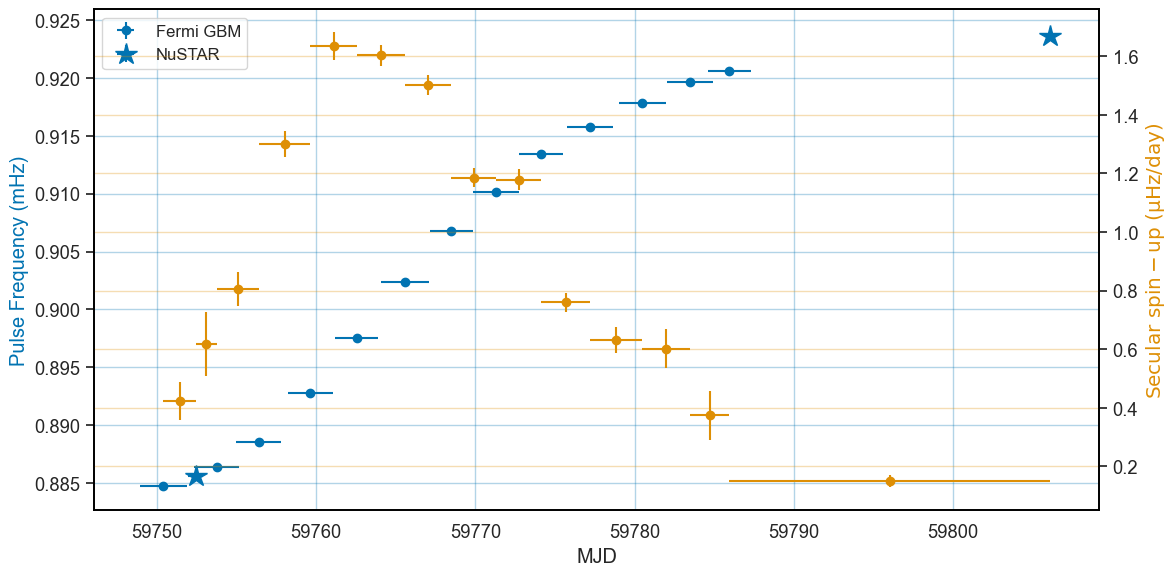

In [8]:
fig, host = plt.subplots(figsize=(12,6))
par1 = host.twinx()

pl1 = host.errorbar(pulse_data['PSRTIME'][mask], pulse_data['FREQUENCY'][mask]*1000, xerr=(pulse_data['TSTOP'][mask]-pulse_data['TSTART'][mask])/2, yerr=pulse_data['FREQUENCY_ERR'][mask]*1000, ls='', fmt='.', label='Fermi GBM', color='C0', markersize=12)
pl2 = host.errorbar(nustar_times, nustar_freqs*1000, xerr=nustar_time_err, yerr=nustar_freq_err*1000, fmt='*', markersize=16, label= 'NuSTAR', color='C0')
host.set_xlabel('MJD')
host.set_ylabel('Pulse Frequency (mHz)')


pl3 = par1.errorbar(fdot_mjd, fdot_mHzperday*1000, xerr=fdot_mjd_err, yerr=fdot_mHzperday_err*1000, ls='', fmt='.', markersize=12, color='C1')
par1.set_ylabel(r'$\mathrm{Secular\ spin-up\ (\mu Hz/day)}$')
host.yaxis.label.set_color('C0')

host.grid(visible=True, color='C0', alpha=0.3)
par1.grid(visible=True, color='C1', alpha=0.3)
par1.yaxis.label.set_color('C1')
host.legend(loc=2, fontsize=12)
plt.tight_layout()
plt.savefig(root_dir + 'figures/pulse_history_f_fdot.pdf')

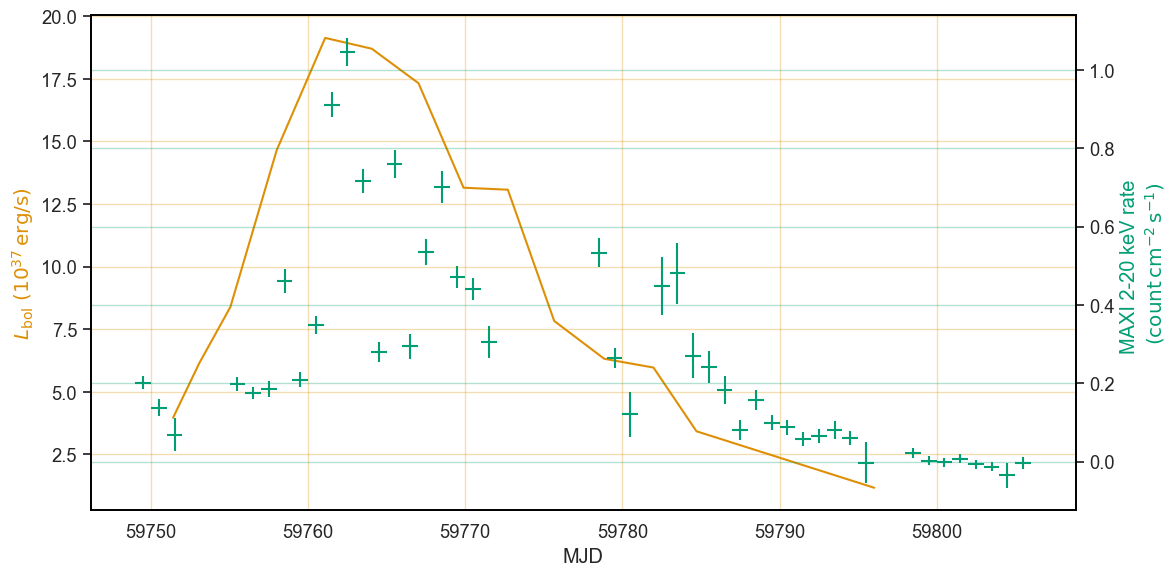

In [11]:
fig, host = plt.subplots(figsize=(12,6))
par1 = host.twinx()

# pl1 = host.errorbar((pulse_data['PSRTIME'][mask]+1.5)[:-1], (pulse_data['FREQUENCY'][mask][1:] - pulse_data['FREQUENCY'][mask][:-1])*1000/3, xerr=1.5, \
#                     yerr=np.sqrt(np.square(pulse_data['FREQUENCY_ERR'][mask][1:]) + np.square(pulse_data['FREQUENCY_ERR'][mask][:-1]))*1000/3, \
#                     ls='', fmt='.', markersize=12)
pl1 = host.plot(fdot_mjd, Ghosh_Lamb_L37(fdot_mHzperday, mu30=1.8), color='C1')
# plt.xlim(59745, 59792)
# plt.ylim(0.88, 0.925)
host.set_xlabel('MJD')
host.set_ylabel(r'$L_{\mathrm{bol}}\ (10^{37}\,\mathrm{erg/s})$')
host.yaxis.label.set_color('C1')

pl3 = par1.errorbar(maxi_lc['MJD'][maxi_mask], maxi_lc['rate 2-20keV'][maxi_mask], xerr=0.5, yerr=maxi_lc['err 2-20keV'][maxi_mask], fmt='', ls='', color='C2', zorder=0, label= 'MAXI rate \n (2-20 keV)')
host.grid(visible=True, color='C1', alpha=0.3)
par1.grid(visible=True, color='C2', alpha=0.3)
par1.set_ylabel('MAXI 2-20 keV rate \n' + r'$(\mathrm{count\,cm^{-2}\,s^{-1}})$')
par1.yaxis.label.set_color('C2')
plt.tight_layout()
plt.savefig(root_dir + 'figures/Ghosh_Lamb_Luminosity.pdf')

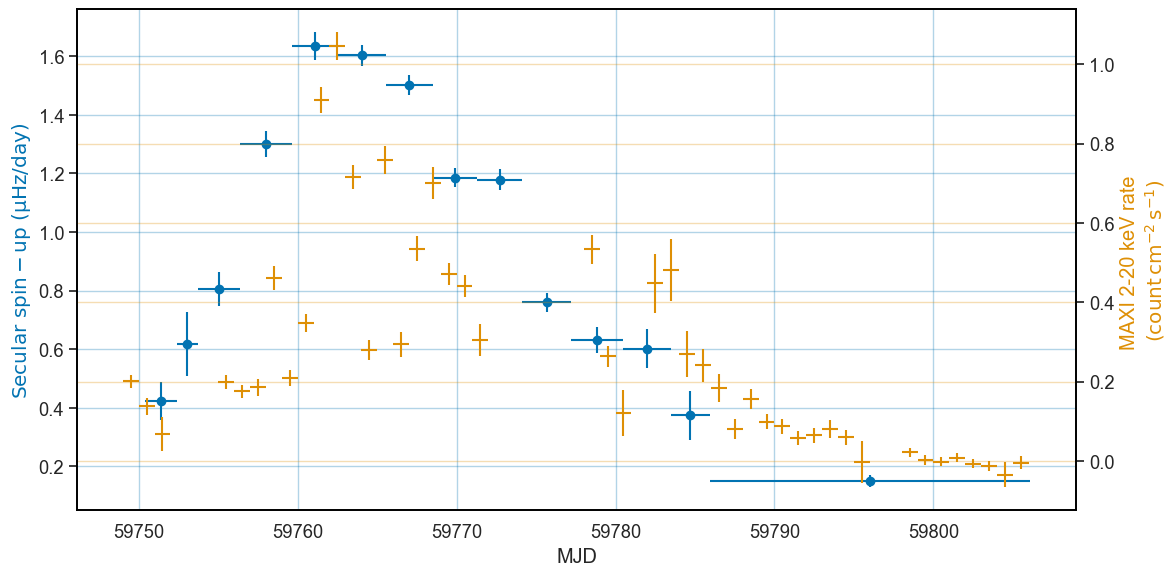

In [7]:
fig, host = plt.subplots(figsize=(12,6))
par1 = host.twinx()

pl1 = host.errorbar(fdot_mjd, fdot_mHzperday*1000, xerr=fdot_mjd_err, yerr=fdot_mHzperday_err*1000, ls='', fmt='.', markersize=12)
# plt.xlim(59745, 59792)
# plt.ylim(0.88, 0.925)
host.set_xlabel('MJD')
host.set_ylabel(r'$\mathrm{Secular\ spin-up\ (\mu Hz/day)}$')
host.yaxis.label.set_color('C0')

pl3 = par1.errorbar(maxi_lc['MJD'][maxi_mask], maxi_lc['rate 2-20keV'][maxi_mask], xerr=0.5, yerr=maxi_lc['err 2-20keV'][maxi_mask], fmt='', ls='', color='C1', zorder=0, label= 'MAXI rate \n (2-20 keV)')
host.grid(visible=True, color='C0', alpha=0.3)
par1.grid(visible=True, color='C1', alpha=0.3)
par1.set_ylabel('MAXI 2-20 keV rate \n' + r'$(\mathrm{count\,cm^{-2}\,s^{-1}})$')
par1.yaxis.label.set_color('C1')
plt.tight_layout()
plt.savefig(root_dir + 'figures/pulse_history_fdot.pdf')

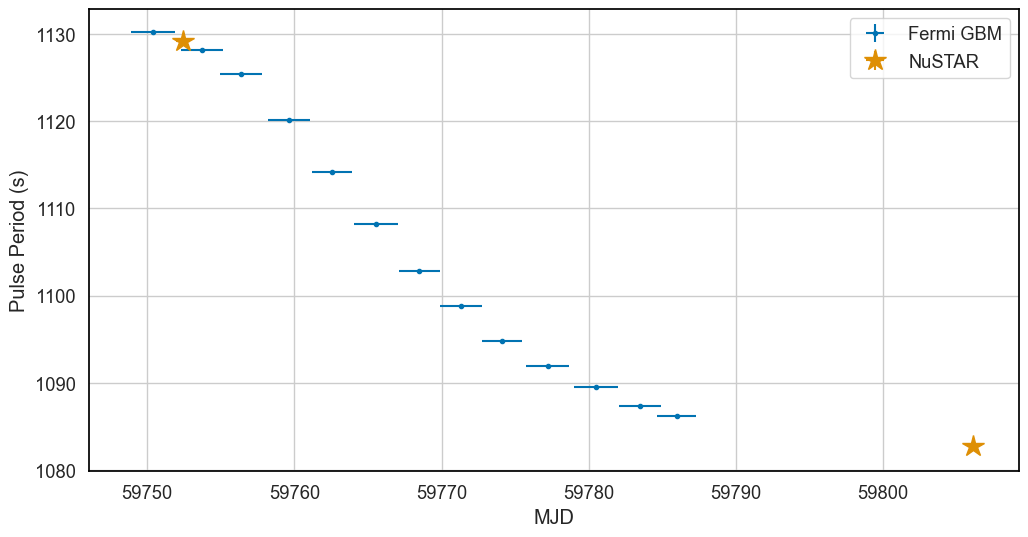

In [50]:
plt.figure(figsize=(12,6))
plt.errorbar(pulse_data['PSRTIME'][mask], 1/pulse_data['FREQUENCY'][mask], xerr=(pulse_data['TSTOP'][mask]-pulse_data['TSTART'][mask])/2, yerr=pulse_data['FREQUENCY_ERR'][mask]/(pulse_data['FREQUENCY'][mask]**2), ls='', fmt='.', label='Fermi GBM')
plt.errorbar(nustar_times, 1/nustar_freqs, xerr=nustar_time_err, yerr=nustar_freq_err/(nustar_freqs**2), fmt='*', markersize=16, label= 'NuSTAR')
# plt.xlim(59745, 59792)
# plt.ylim(1/0.000925, 1/0.00088)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Pulse Period (s)')
plt.savefig(root_dir + 'figures/gbm_pulse_history_period_nharm4.pdf')

/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_16443/3123401235.py:23: RuntimeWarning: divide by zero encountered in true_divide
  hardness_err.append(temp_hardness*np.sqrt(np.square(maxi_lc['err 10-20keV'][i]/maxi_lc['rate 10-20keV'][i]) + \
/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_16443/3123401235.py:23: RuntimeWarning: invalid value encountered in multiply
  hardness_err.append(temp_hardness*np.sqrt(np.square(maxi_lc['err 10-20keV'][i]/maxi_lc['rate 10-20keV'][i]) + \
/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_16443/3123401235.py:35: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  hard = np.array(hard, dtype=float)
/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_16443/3123401235.py:36: De

[ True  True False ...  True  True  True]


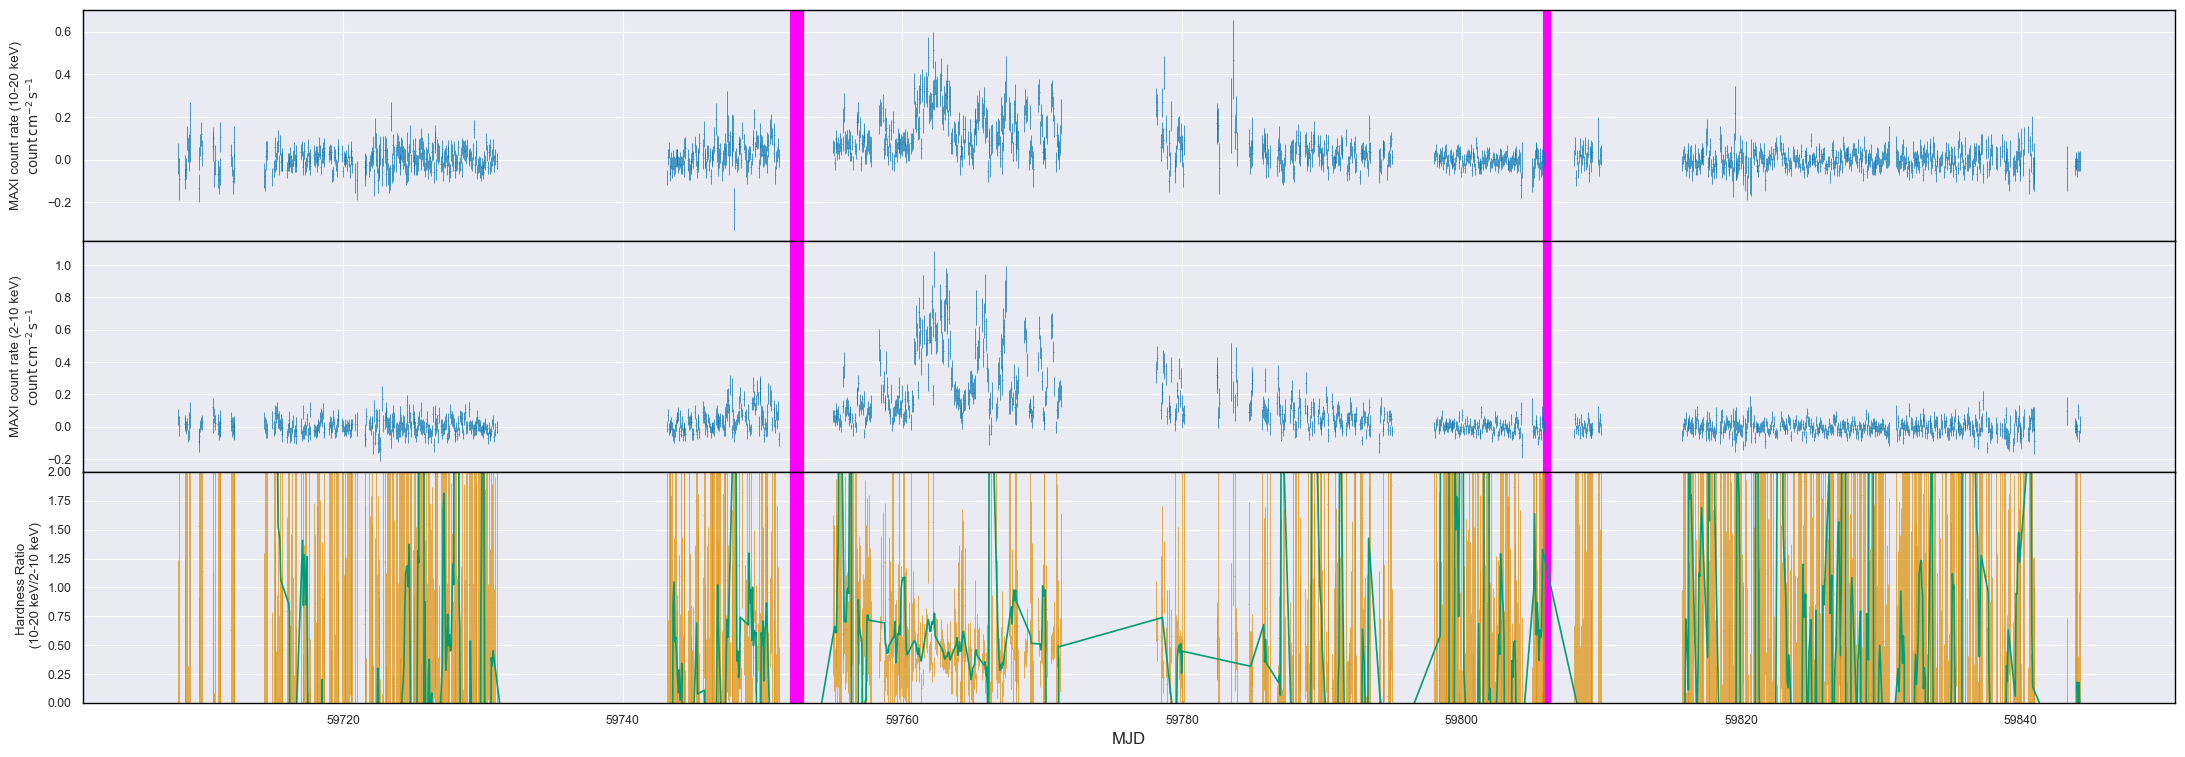

In [96]:
maxi_lc = ascii.read(root_dir + 'MAXI/J0655-014_g_lc_1orb_all.dat', names = ['MJD', 'rate 2-20keV', 'err 2-20keV', \
                                                                             'rate 2-4keV', 'err 2-4keV', \
                                                                             'rate 4-10keV', 'err 4-10keV', \
                                                                             'rate 10-20keV', 'err 10-20keV'])

time = np.arange(59708.218750, 59844.218750 + 3/(2*24),3/(2*24))
hard = []
hard_err = []
soft = []
soft_err = []
hardness = []
hardness_err = []

for t in time:
    if t in maxi_lc['MJD']:
        i = np.argwhere(maxi_lc['MJD']==t)
        hard.append(maxi_lc['rate 10-20keV'][i])
        hard_err.append(maxi_lc['err 10-20keV'][i])
        soft.append(maxi_lc['rate 2-4keV'][i] + maxi_lc['rate 4-10keV'][i])
        soft_err.append(np.sqrt(np.square(maxi_lc['err 2-4keV'][i]) + np.square(maxi_lc['err 4-10keV'][i])))
        temp_hardness = maxi_lc['rate 10-20keV'][i]/(maxi_lc['rate 2-4keV'][i] + maxi_lc['rate 4-10keV'][i])
        hardness.append(temp_hardness)
        hardness_err.append(temp_hardness*np.sqrt(np.square(maxi_lc['err 10-20keV'][i]/maxi_lc['rate 10-20keV'][i]) + \
                                                  np.square(np.sqrt(np.square(maxi_lc['err 2-4keV'][i]) + \
                                                                    np.square(maxi_lc['err 4-10keV'][i]))/\
                                                            (maxi_lc['rate 2-4keV'][i] + maxi_lc['rate 4-10keV'][i]))))
    else:
        hard.append(np.inf)
        hard_err.append(np.inf)
        soft.append(np.inf)
        soft_err.append(np.inf)
        hardness.append(np.inf)
        hardness_err.append(np.inf)
        
hard = np.array(hard, dtype=float)
hard_err = np.array(hard_err, dtype=float)
soft = np.array(soft, dtype=float)
soft_err = np.array(soft_err, dtype=float)
hardness = np.array(hardness, dtype=float)
hardness_err = np.array(hardness_err, dtype=float)

time_mask = (hard != np.inf)
print(time_mask)

moving_hardness = moving_average(hardness, 5)
moving_mask = (moving_hardness != np.inf)

fig, axes = plt.subplots(3, 1, figsize = (27, 9), gridspec_kw={'hspace':0}, sharex=True)

axes[0].errorbar(time[time_mask], hard[time_mask], xerr= 3/(24*4), yerr=hard_err[time_mask], fmt='', ls='', lw=0.5)
axes[1].errorbar(time[time_mask], soft[time_mask], xerr= 3/(24*4), yerr=soft_err[time_mask], fmt='', ls='', lw=0.5)
axes[2].errorbar(time[time_mask], hardness[time_mask], xerr= 3/(24*4), yerr=hardness_err[time_mask], fmt='', ls='', color='C1', lw=0.5)
axes[2].plot(time[moving_mask], moving_hardness[moving_mask], color='C2')
axes[2].set_ylim(0, 2)
# axes[2].set_xlim(59758, 59771)

for ax in axes:
    ax.axvspan(nustar_obs1[0], nustar_obs1[1], color= 'magenta')
    ax.axvspan(nustar_obs2[0], nustar_obs2[1], color= 'magenta')

axes[0].set_ylabel('MAXI count rate (10-20 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')   
axes[1].set_ylabel('MAXI count rate (2-10 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')  
axes[2].set_ylabel('Hardness Ratio \n (10-20 keV/2-10 keV)')    
                 
# axes[0].annotate('Swift BAT 15-150 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[1].annotate('MAXI 2-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[2].annotate('MAXI 2-4 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[3].annotate('MAXI 4-10 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[4].annotate('MAXI 10-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[5].annotate('MAXI HR', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)

axes[2].set_xlabel('MJD', fontsize=12)
plt.savefig(root_dir + 'figures/MAXI_hardness_orb.pdf')


0.00018531284041394336


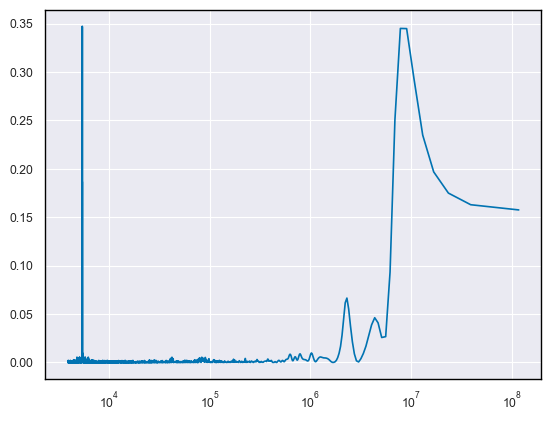

In [122]:
maxi_lc = ascii.read(root_dir + 'MAXI/J0655-014_g_lc_1orb_all.dat', names = ['MJD', 'rate 2-20keV', 'err 2-20keV', \
                                                                             'rate 2-4keV', 'err 2-4keV', \
                                                                             'rate 4-10keV', 'err 4-10keV', \
                                                                             'rate 10-20keV', 'err 10-20keV'])
frequency, power = LombScargle(maxi_lc['MJD']*24*3600, maxi_lc['rate 2-20keV'], dy = maxi_lc['err 2-20keV']).autopower()
plt.plot(1/frequency, power)
plt.xscale('log')
print(frequency[np.argmax(power)])

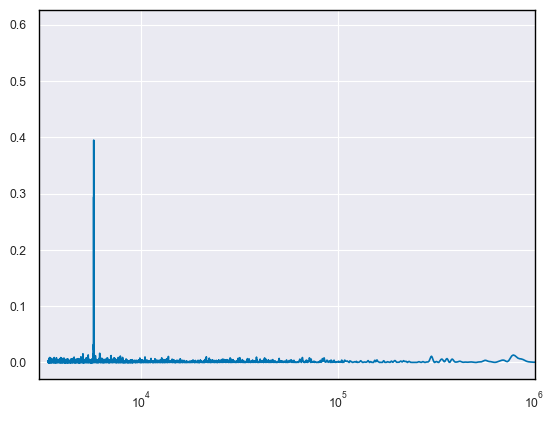

In [120]:
bat_lc = fits.open(root_dir + 'MAXI/MAXIJ0655-013.orbit.lc.fits')[1].data

frequency, power = LombScargle(bat_lc['TIME'], bat_lc['RATE'], dy = bat_lc['ERROR']).autopower()
plt.plot(1/frequency, power)
plt.xlim(left=3e3, right=1e6)
plt.xscale('log')